In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')

pyro.enable_validation(True)
pyro.set_rng_seed(0)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## Data

In [3]:
DATA_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/refs/heads/master/data/rugged.csv"
data = pd.read_csv(DATA_URL, sep=';')
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [4]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

Convert the Numpy array behind the dataframe to `torch.Tensor` for analysis with PyTorch and Pyro.

In [5]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

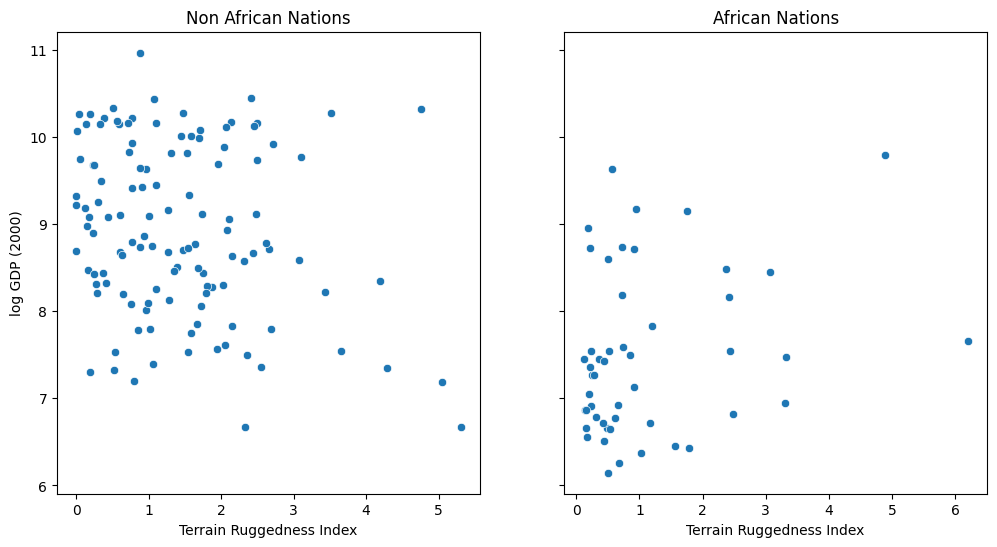

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
								y=non_african_nations["rgdppc_2000"],
								ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
					ylabel="log GDP (2000)",
					title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
								y=african_nations["rgdppc_2000"],
								ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
					ylabel="log GDP (2000)",
					title="African Nations");

## Maximul-likelihood linear regression

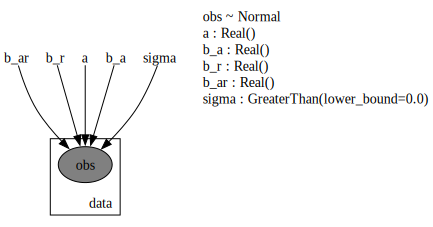

In [7]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
	a = pyro.param("a", lambda: torch.randn(()))
	b_a = pyro.param("b_a", lambda: torch.randn(()))
	b_r = pyro.param("b_r", lambda: torch.randn(()))
	b_ar = pyro.param("b_ar", lambda: torch.randn(()))
	sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

	mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

	with pyro.plate("data", len(ruggedness)):
		return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp),
									render_distributions=True,
									render_params=True)

## MLE to Bayesian

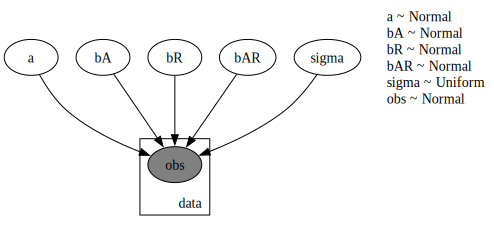

In [8]:
def model(is_cont_africa, ruggedness, log_gdp=None):
	a = pyro.sample("a", dist.Normal(0., 10.))
	b_a = pyro.sample("bA", dist.Normal(0., 1.))
	b_r = pyro.sample("bR", dist.Normal(0., 1.))
	b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
	sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

	mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

	with pyro.plate("data", len(ruggedness)):
			return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

### Custom Guide

In [9]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
	a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
	a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
											constraint=constraints.positive)
	sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))
	weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
	weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
															 constraint=constraints.positive)

	a = pyro.sample("a", dist.Normal(a_loc, a_scale))
	b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
	b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
	b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
	sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))  # fixed scale for simplicity

	return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

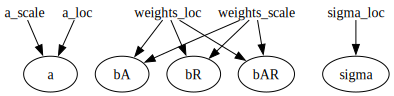

In [10]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

The simplest autoguide class is `AutoNormal`, which automatically generates a guide in a single line of code that is equivalent to the one we wrote above.

In [11]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

### Bayesian regression via stochastic variational inference (SVI)

In [12]:
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 703.4024093747139
Elbo loss: 533.9181485772133
Elbo loss: 471.51326072216034
Elbo loss: 396.7230395078659
Elbo loss: 317.46917176246643
Elbo loss: 265.4496731162071
Elbo loss: 252.16884714365005
Elbo loss: 247.65427941083908
Elbo loss: 255.26826179027557
Elbo loss: 248.15622454881668


CPU times: user 9.23 s, sys: 328 ms, total: 9.56 s
Wall time: 9.95 s


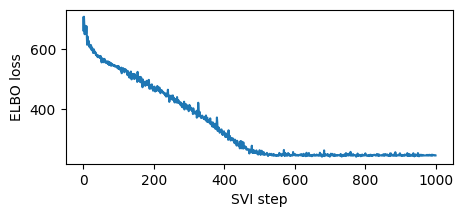

In [13]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
  print(name, pyro.param(name).data.cpu())

AutoNormal.locs.a tensor(9.1817)
AutoNormal.scales.a tensor(0.0694)
AutoNormal.locs.bA tensor(-1.8297)
AutoNormal.scales.bA tensor(0.1674)
AutoNormal.locs.bR tensor(-0.1794)
AutoNormal.scales.bR tensor(0.0447)
AutoNormal.locs.bAR tensor(0.3461)
AutoNormal.scales.bAR tensor(0.0966)
AutoNormal.locs.sigma tensor(-2.2513)
AutoNormal.scales.sigma tensor(0.0663)


In [15]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

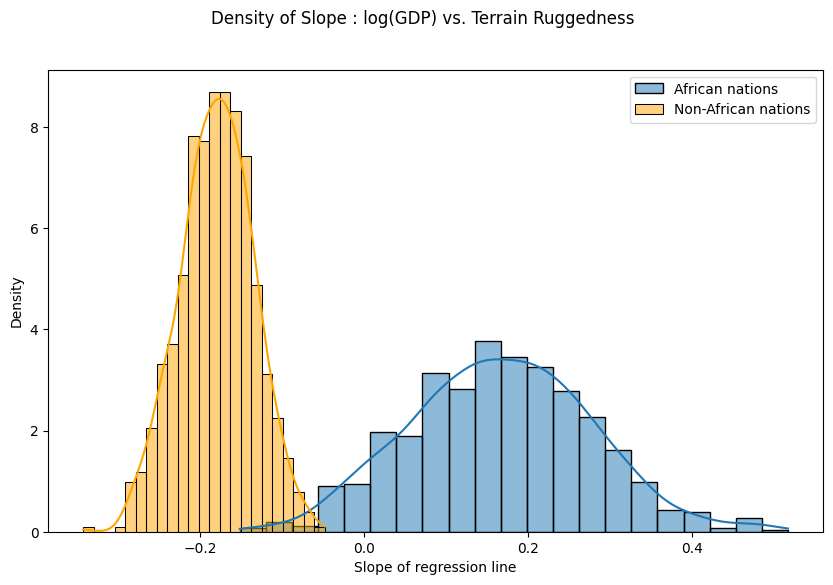

In [16]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [17]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

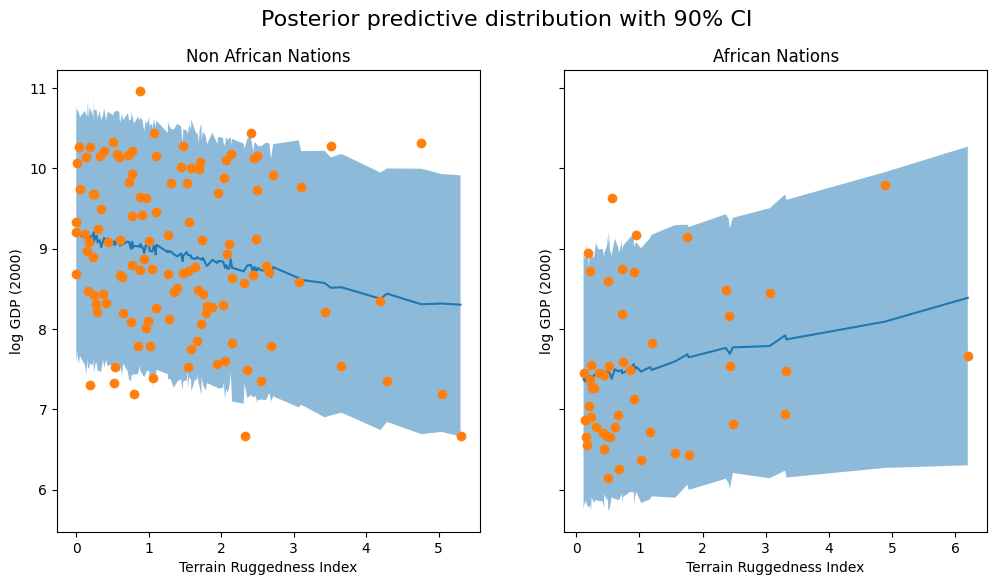

In [18]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [19]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

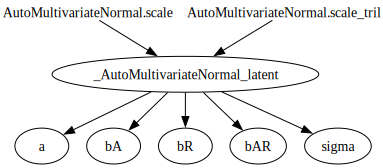

In [20]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Elbo loss: 839.0326555967331
Elbo loss: 586.3271330595016
Elbo loss: 542.173867225647
Elbo loss: 502.35264986753464
Elbo loss: 418.7747150659561
Elbo loss: 351.225014090538
Elbo loss: 254.91623198986053
Elbo loss: 255.13915133476257
Elbo loss: 247.63430547714233
Elbo loss: 247.33513009548187


CPU times: user 48.1 s, sys: 1.75 s, total: 49.9 s
Wall time: 9.68 s


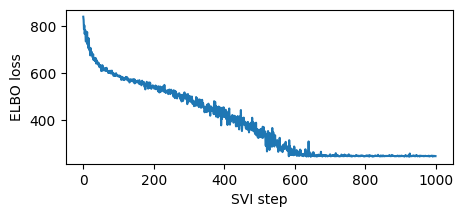

In [21]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

/var/folders/fc/szc97hhx4sgg1mzfl9bt0n240000gn/T/ipykernel_74600/3705028035.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
/var/folders/fc/szc97hhx4sgg1mzfl9bt0n240000gn/T/ipykernel_74600/3705028035.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)


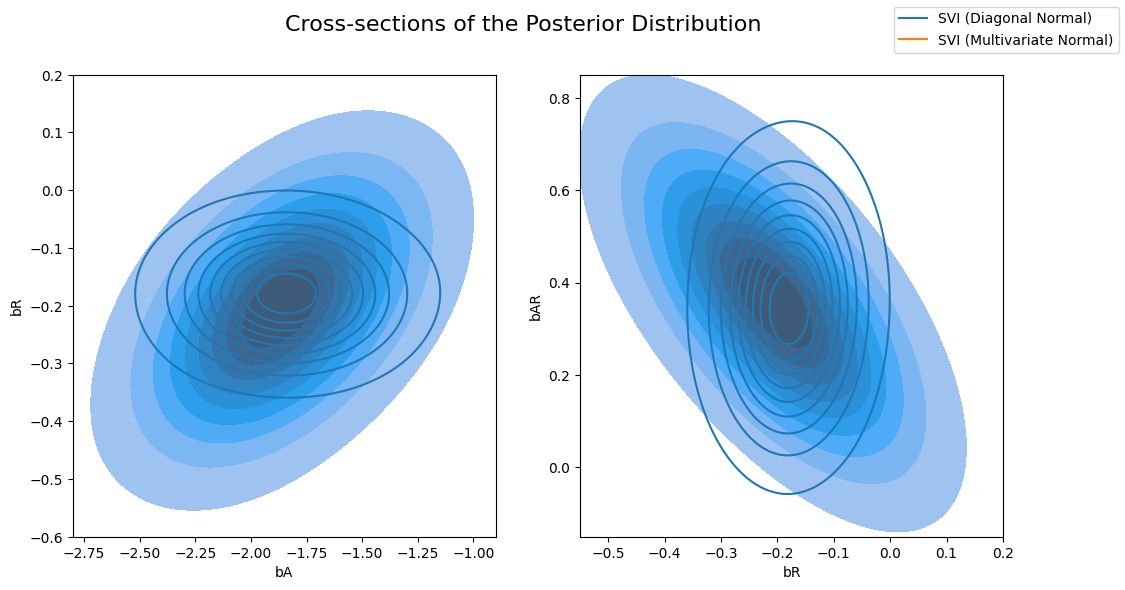

In [22]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

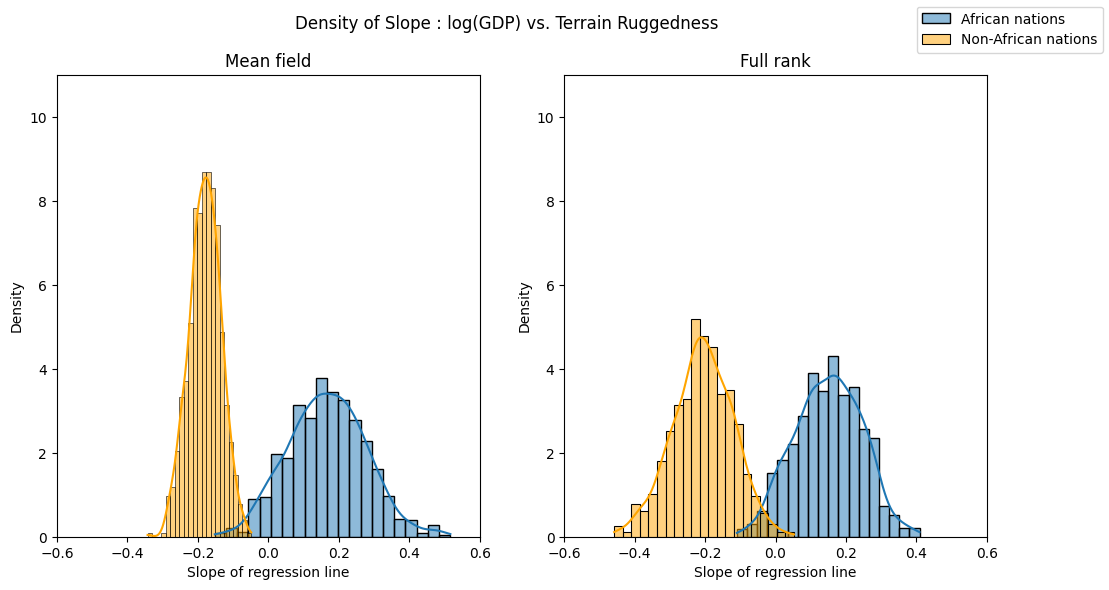

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

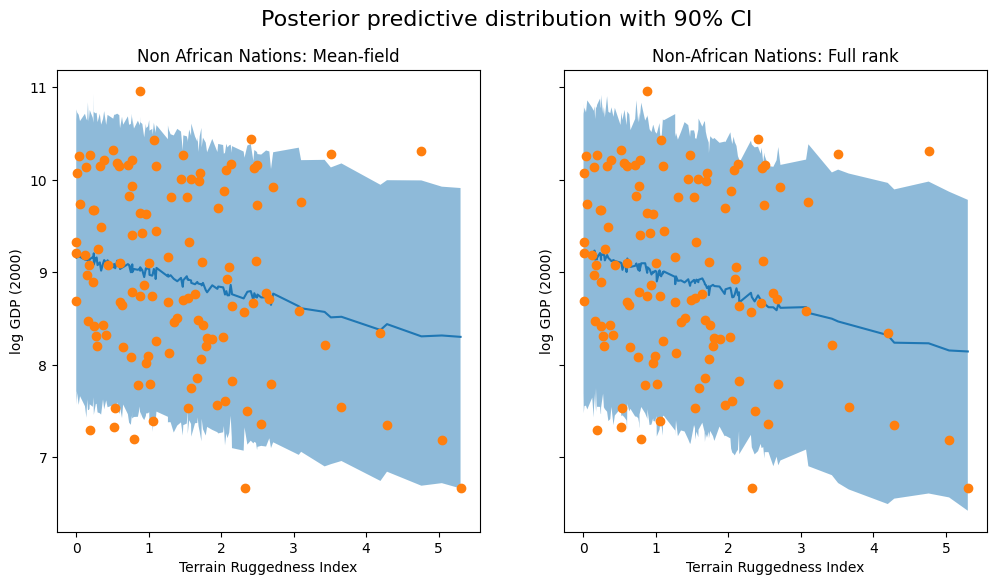

In [24]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");